# Strategy Details


According to the essay "Statistical arbitrage strategy based on VIX-to-market based signal" published by Tuomas Lehtinen in 2022, the writer use the two days consecutive & positive co-movement between S&P500 and VIX index as singal, after that at day 2 we have the signal.

From that we will short the S&P500 for 2 days and next 2 days long the market again. The essay consider excess return, Jensen Alpha, security market line etc. The essay find out such signal may generate better return and Sharpe ratio comparing with S&P500. 

Since here we want to replicate his ideas and findings for backtesting, we simplify his actions into this:
1. We two days (t &t+1)  consecutive & positive co-movement between S&P500 and VIX index as singal. We record the signal at t+1 day
2. Next day (t+2) we will short short S&P500 for two days 
3. Then at t+4 day we long S&P500 for two days

We don't consider risk free risk and transcation costs.

Our time frame is from 2000-01-02 to 2024-05-31

| Date| S&P500 return| VIX return |Signal| action|
|:---------|:--------:|---------:|---------:|---------:|
| t  |+|+ | 0|   |
| t+1  |+| + |   1 | |
|  t+2  | | |   | short S&P500|
|  t+3  ||  |   | short S&P500|
|  t+4  || |  | long S&P500|
|  t+5 || |  | long S&P500|

Note that the essay considered abnormal return and signal based on a longer period of time for academic purpose, in here we simply find out signal based on the daily return of S&P500 and VIX, so in case of more than 2 days co-movement, signal will be recorded more than once, thus two or more trades will be conducted and partly overlapped. But in the essay the writer did remove the overlapping situation.

In [19]:
#load the data and combine into one dataframe for analysis
import os
import requests
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

def load_data(symbol):
    
    direc = 'data/'
    os.makedirs(direc, exist_ok=True)
    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):
        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2000-01-02', end='2024-05-31')
        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).date

    return df

# I know that these two are not tradaable, but I want to use them as a proxy of
# their futures.
tickers=["^GSPC","^VIX"]
holder = {}
for symbol in tickers:
    df = load_data(symbol)

    df["same_day_return"] = df["Close"]/df["Open"] -1
    df["next_day_return"] = df["same_day_return"].shift(-1)
    
    df['return'] = df['Close'].pct_change()

    df['return_sign'] = np.nan
    df.loc[df['return'] > 0, 'return_sign'] = 1
    df.loc[df['return'] < 0, 'return_sign'] = -1

    df['rolling_sum'] = df['return_sign'].rolling(window=2).sum()

    holder[symbol] = df


Now we will try to backtest such signal:

After the signal, we first short 2 days S&P500 and then long two days S&P500

In [20]:
rolling_sum_holder = []
next_day_return_holder = []

for symbol in tickers:

    rolling_sum_series = holder[symbol]['rolling_sum']
    next_day_return_series = holder[symbol]['next_day_return']

    rolling_sum_series.name = symbol
    next_day_return_series.name = symbol

    rolling_sum_holder.append(rolling_sum_series)
    next_day_return_holder.append(next_day_return_series)

rolling_sum_df = pd.concat(rolling_sum_holder, axis=1)
next_day_return_df = pd.concat(next_day_return_holder, axis=1)

mask_both_positive_2 = rolling_sum_df.sum(axis=1, skipna=True) == 4
mask_both_negative_2 = rolling_sum_df.sum(axis=1, skipna=True) == -4

returns_df = pd.DataFrame(columns=next_day_return_df.columns, index=next_day_return_df.index)
returns_df.iloc[:, :] = np.nan

returns_df.loc[mask_both_positive_2, '^VIX'] = next_day_return_df.loc[mask_both_positive_2, '^VIX']
returns_df.loc[mask_both_positive_2, '^GPSC'] = -next_day_return_df.loc[mask_both_positive_2, '^GSPC']

returns_df.loc[mask_both_negative_2, '^VIX'] = -next_day_return_df.loc[mask_both_negative_2, '^VIX']
returns_df.loc[mask_both_negative_2, '^GPSC'] = next_day_return_df.loc[mask_both_negative_2, '^GSPC']

portfolio_return = returns_df.sum(axis=1, skipna=True)

sharp_ratio = portfolio_return.mean() / portfolio_return.std() * np.sqrt(252)

# data["signal"]=0
# testing=pd.DataFrame()
# acc_return=0
# count=0
# return_mean=[]
# ret=0
# for a in range(len(data)-1):
#     if (data["same_day_return_^GSPC"][a] >0) & (data["same_day_return_^GSPC"][a] >0) & (data["same_day_return_^GSPC"][a+1] >0) & (data["same_day_return_^GSPC"][a+1] >0):
#         data["signal"][a+1]=1
#         testing=pd.concat([testing,data[a:a+5]],ignore_index=True)
#         ret+=(-data["next_day_return_^GSPC"][a+1:a+3]).sum() + (data["next_day_return_^GSPC"][a+3:a+5]).sum()
#         acc_return+=ret
#         count+=1
#         return_mean.append(ret)
# display(testing)
# risk=np.std(return_mean)
# sharpe=np.mean(return_mean)/risk*np.sqrt(50) 
# print("Return: ", acc_return)
# print("Sharpe ratio: ",sharpe)
# print("Count of trades: ", count)
# print("")

From that we can produce similar results using such strategy, but:

1. We ignore risk free rate and transcation cost, and thus we have a higher than normal sharpe ratio.
2. We have much more signal and thus much more trades, thus in reality we will have much lower return.
3. More research is required to find out the better combo of days of shorting and longing S&P500.
4. How to deal with overlapping signal? Do more separate trades like here? Or continute the existing one or something else?
5. We may also consider longer days of co-movement.
6. Over time S&P500 is bullish, that signal might be able to capture short term corrections. But what if the US stock bullish market end?

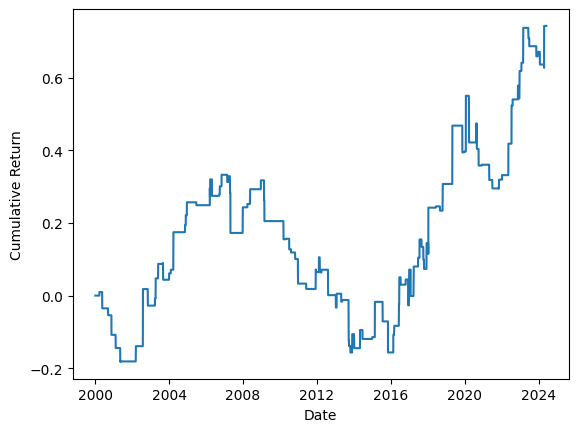

In [21]:
cumsum = portfolio_return.cumsum()

plt.plot(cumsum)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()